# Import and install

In [1]:
import os
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# model
from tensorflow.keras.applications import EfficientNetB3, ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as dn_pre
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

# Reproducible
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Thông số
IMAGE_DIM = 300
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Đường dẫn
train_dir = '/kaggle/input/dog-vs-cat-classification/train/train'
cat_dir = os.path.join(train_dir, 'cats')
dog_dir = os.path.join(train_dir, 'dogs')

2025-10-17 05:43:37.961099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760679817.983875    1924 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760679817.991075    1924 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load data

In [2]:
cat_files = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
dog_files = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]

all_files = cat_files + dog_files
labels = [0] * len(cat_files) + [1] * len(dog_files)  # 0: cat, 1: dog

# Shuffle và split - Trộn và chia dữ liệu
combined = list(zip(all_files, labels))
random.shuffle(combined)
all_files, labels = zip(*combined)
all_files = list(all_files)
labels = list(labels)

# Chia train/validation với tỉ lệ 80/20
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=SEED, stratify=labels
)

print("Train size:", len(train_files), "Val size:", len(val_files))

Train size: 20000 Val size: 5000


# Chuyển đổi Albumentations

In [3]:
train_aug = A.Compose([
    A.Resize(IMAGE_DIM, IMAGE_DIM),  # Thay đổi kích thước
    A.HorizontalFlip(p=0.5),         # Lật ngang ảnh (50% xác suất)
    A.Rotate(limit=10, p=0.5),       # Xoay ảnh ±10 độ
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),  # Tạo lỗ hổng
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Chuẩn hóa
])

val_aug = A.Compose([
    A.Resize(IMAGE_DIM, IMAGE_DIM),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

/tmp/ipykernel_1924/1255227927.py:5: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),  # Tạo lỗ hổng


# Hàm đọc ảnh + augment (OpenCV + Albumentation)


### + Lưu ý: OpenCV đọc ảnh mặc định là BGR nên phải chuyển đổi định dạng ảnh sang RGB -> Vì Albumentations sử dụng định dạng ảnh RGB phổ biến và thông dụng nhất

In [4]:
def read_and_preprocess_image(path, label, is_training=True):
    def _read_image(path_str):
        path_str = path_str.numpy().decode('utf-8') if isinstance(path_str, tf.Tensor) else str(path_str)
        
        # Đọc ảnh với OpenCV
        img = cv2.imread(path_str, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển BGR sang RGB
        return img

    def _augment_image(img, is_training):
        # Áp dụng augmentation
        if is_training:
            augmented = train_aug(image=img)
        else:
            augmented = val_aug(image=img)
        return augmented['image'].astype(np.float32)

    image = _read_image(path)
    image = _augment_image(image, is_training)
    return image, label

def tf_load_image_wrapper(path, label, is_training=True):
    def _py_function_wrapper(path_tensor, label_tensor):
        # Wrapper để tích hợp với TensorFlow
        image, label = tf.py_function(
            func=lambda p, l: read_and_preprocess_image(p, l, is_training),
            inp=[path_tensor, label_tensor],
            Tout=[tf.float32, tf.int32]
        )
        return image, label
    
    image, label = _py_function_wrapper(path, label)
    # Set shape cố định cho tensor
    image.set_shape([IMAGE_DIM, IMAGE_DIM, 3])
    label.set_shape([])
    return image, label

def make_dataset(file_list, label_list, batch_size, is_training=True):
    # Tạo dataset từ danh sách file
    ds = tf.data.Dataset.from_tensor_slices((file_list, label_list))
    if is_training:
        ds = ds.shuffle(buffer_size=len(file_list), seed=SEED, reshuffle_each_iteration=True)
    
    # Ánh xạ hàm xử lý ảnh
    ds = ds.map(lambda p, l: tf_load_image_wrapper(p, l, is_training), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)  # Chia thành batches
    ds = ds.prefetch(AUTOTUNE)  # Tải trước dữ liệu để tăng tốc
    return ds

# Định nghĩa các base model

In [5]:
def build_efficientnetb3_base(input_shape=(IMAGE_DIM, IMAGE_DIM, 3), trainable_layers=10):
    """EfficientNetB3 với fine-tuning từng phần"""
    base = EfficientNetB3(
        weights='imagenet',      # Sử dụng weights pretrained
        include_top=False,       # Không lấy phần classifier
        input_shape=input_shape
    )
    
    # Freeze toàn bộ ban đầu
    base.trainable = False
    
    # Mở freeze cho các layer cuối
    if trainable_layers > 0:
        base.trainable = True
        # Chỉ train các layer cuối
        for layer in base.layers[:-trainable_layers]:
            layer.trainable = False
        # Luôn freeze BatchNorm
        for layer in base.layers:
            if isinstance(layer, layers.BatchNormalization):
                layer.trainable = False
    
    inp = keras.Input(shape=input_shape)
    x = eff_preprocess(inp)
    x = base(x, training=base.trainable)  # Quan trọng: training=True khi fine-tuning
    x = layers.GlobalAveragePooling2D()(x)
    
    model = keras.Model(inp, x, name=f'EfficientNetB3_Feature_{trainable_layers}L')
    print(f"✓ EfficientNetB3: {trainable_layers} layers trainable")
    return model

def build_resnet50_base(input_shape=(IMAGE_DIM, IMAGE_DIM, 3), trainable_layers=15):
    """ResNet50 với fine-tuning từng phần"""
    base = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Freeze toàn bộ ban đầu
    base.trainable = False
    
    # Mở freeze cho các layer cuối
    if trainable_layers > 0:
        base.trainable = True
        # Chỉ train các layer cuối (ResNet có ~175 layers)
        for layer in base.layers[:-trainable_layers]:
            layer.trainable = False
        # Luôn freeze BatchNorm
        for layer in base.layers:
            if isinstance(layer, layers.BatchNormalization):
                layer.trainable = False
    
    inp = keras.Input(shape=input_shape)
    x = resnet_preprocess(inp)
    x = base(x, training=base.trainable)
    x = layers.GlobalAveragePooling2D()(x)
    
    model = keras.Model(inp, x, name=f'ResNet50_Feature_{trainable_layers}L')
    print(f"✓ ResNet50: {trainable_layers} layers trainable")
    return model

def build_seresnext50_base(input_shape=(IMAGE_DIM, IMAGE_DIM, 3), trainable_layers=12):
    """SEResNeXt50 với fine-tuning từng phần"""
    base = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    base.trainable = False
    
    if trainable_layers > 0:
        base.trainable = True
        for layer in base.layers[:-trainable_layers]:
            layer.trainable = False
        for layer in base.layers:
            if isinstance(layer, layers.BatchNormalization):
                layer.trainable = False
    
    inp = keras.Input(shape=input_shape)
    x = resnet_preprocess(inp)
    x = base(x, training=base.trainable)
    
    # Thêm SE attention
    f = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(f//16, activation='relu')(se)
    se = layers.Dense(f, activation='sigmoid')(se)
    se = layers.Reshape((1,1,f))(se)
    x = layers.Multiply()([x, se])
    x = layers.GlobalAveragePooling2D()(x)
    
    model = keras.Model(inp, x, name=f'SEResNeXt50_Feature_{trainable_layers}L')
    print(f"✓ SEResNeXt50: {trainable_layers} layers trainable")
    return model

def build_densenet121_base(input_shape=(IMAGE_DIM, IMAGE_DIM, 3), trainable_layers=20):
    """DenseNet121 với fine-tuning từng phần"""
    base = DenseNet121(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    base.trainable = False
    
    if trainable_layers > 0:
        base.trainable = True
        for layer in base.layers[:-trainable_layers]:
            layer.trainable = False
        for layer in base.layers:
            if isinstance(layer, layers.BatchNormalization):
                layer.trainable = False
    
    inp = keras.Input(shape=input_shape)
    x = dn_pre(inp)
    x = base(x, training=base.trainable)
    x = layers.GlobalAveragePooling2D()(x)
    
    model = keras.Model(inp, x, name=f'DenseNet121_Feature_{trainable_layers}L')
    print(f"✓ DenseNet121: {trainable_layers} layers trainable")
    return model


# Optimized probability analysis

In [6]:
def get_pred_proba(model, dataset):
    """
    Trả về xác suất dự đoán (softmax) của model.
    - Tự nhận biết model có nhiều output hay 1 output.
    - Không load từng batch thủ công => dùng predict(dataset).
    - Giảm RAM, phù hợp cho Kaggle.
    """
    print(f"→ Predicting probabilities for: {model.name} ...")
    preds = model.predict(dataset, verbose=1)
    
    # Nếu multi-output model → lấy output cuối cùng làm chính
    if isinstance(preds, list):
        pred_proba = preds[-1]
    else:
        pred_proba = preds
    return pred_proba

def evaluate_model_probability(model, val_ds, val_labels, model_name="Model"):
    """
    Đánh giá model dựa trên xác suất dự đoán.
    """
    print(f"\n{'='*60}")
    print(f"PROBABILITY ANALYSIS: {model_name}")
    print(f"{'='*60}")
    
    pred_proba = get_pred_proba(model, val_ds)
    pred_classes = np.argmax(pred_proba, axis=1)
    true_classes = np.array(val_labels)
    
    acc = np.mean(pred_classes == true_classes)
    conf = np.mean(np.max(pred_proba, axis=1))
    auc = roc_auc_score(true_classes, pred_proba[:, 1])
    
    high_conf = np.max(pred_proba, axis=1) >= 0.8
    hc_acc = np.mean(pred_classes[high_conf] == true_classes[high_conf]) if np.any(high_conf) else 0
    
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC-ROC : {auc:.4f}")
    print(f"Avg Conf: {conf:.4f}")
    print(f"High-Conf Acc (≥0.8): {hc_acc:.4f} ({np.sum(high_conf)}/{len(pred_proba)})")
    
    return {
        'accuracy': acc,
        'auc_roc': auc,
        'avg_confidence': conf,
        'high_conf_accuracy': hc_acc,
        'pred_proba': pred_proba,
        'model': model
    }

def select_best_models(models_dict, val_data, val_labels, top_k=2):
    print("\nĐANG CHỌN MODEL TỐT NHẤT...")
    results = {n: evaluate_model_probability(m, val_data, val_labels, n) for n, m in models_dict.items()}
    sorted_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    print("\nKẾT QUẢ XẾP HẠNG:")
    for i, (n, r) in enumerate(sorted_models):
        print(f"{i+1:2d}. {n:20} | Acc: {r['accuracy']:.4f} | AUC: {r['auc_roc']:.4f}")
    best = {n: r for n, r in sorted_models[:top_k]}
    print(f"\n→ ĐÃ CHỌN {len(best)} MODEL TỐT NHẤT:")
    for n in best: print(f"   ✓ {n}")
    return best

# Update training strategy

In [7]:
def train_individual_model_with_finetuning(base_model_func, model_name, train_ds, val_ds, 
                                         initial_epochs=3, finetune_epochs=2, finetune_layers=10):
    """
    Train từng model với chiến lược fine-tuning:
    1. Đầu tiên: Freeze toàn bộ, train head
    2. Sau đó: Fine-tuning một phần base model
    """
    print(f"\n TRAINING {model_name} WITH FINE-TUNING STRATEGY")
    print("="*50)
    
    # Bước 1: Freeze toàn bộ base model
    print(f"Bước 1: Training với base model frozen...")
    base_model = base_model_func(trainable_layers=0)  # Hoàn toàn frozen
    
    # Tạo model hoàn chỉnh
    inputs = keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))
    features = base_model(inputs)
    outputs = layers.Dense(2, activation='softmax')(features)
    model = keras.Model(inputs, outputs, name=f'{model_name}_Stage1')
    
    # Compile và train
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"   → Training head với base frozen ({initial_epochs} epochs)...")
    history1 = model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=initial_epochs, 
        verbose=1
    )
    initial_acc = history1.history['val_accuracy'][-1]
    print(f"   ✓ Accuracy sau stage 1: {initial_acc:.4f}")
    
    # Bước 2: Fine-tuning một phần base model
    if finetune_epochs > 0:
        print(f"Bước 2: Fine-tuning {finetune_layers} layers của base model...")
        
        # Tạo model mới với base model trainable một phần
        base_model_finetune = base_model_func(trainable_layers=finetune_layers)
        
        inputs = keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))
        features = base_model_finetune(inputs)
        outputs = layers.Dense(2, activation='softmax')(features)
        model_finetune = keras.Model(inputs, outputs, name=f'{model_name}_Stage2')
        
        # Copy weights từ model đã train
        print("   → Transferring weights từ stage 1...")
        for i, layer in enumerate(model_finetune.layers[1].layers):  # Base model layers
            if i < len(model.layers[1].layers):
                layer.set_weights(model.layers[1].layers[i].get_weights())
        
        # Copy classifier weights
        model_finetune.layers[-1].set_weights(model.layers[-1].get_weights())
        
        # Compile với learning rate nhỏ hơn
        model_finetune.compile(
            optimizer=keras.optimizers.Adam(1e-4),  # LR nhỏ hơn cho fine-tuning
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print(f"   → Fine-tuning với {finetune_epochs} epochs...")
        history2 = model_finetune.fit(
            train_ds, 
            validation_data=val_ds, 
            epochs=finetune_epochs, 
            verbose=1
        )
        final_acc = history2.history['val_accuracy'][-1]
        print(f"   ✓ Accuracy sau fine-tuning: {final_acc:.4f}")
        print(f"   ✓ Improvement: {final_acc - initial_acc:+.4f}")
        
        return model_finetune, history1, history2
    
    return model, history1, None

# Model

In [8]:
def build_single_output_fusion_model(models_dict, input_shape=(IMAGE_DIM, IMAGE_DIM, 3), num_classes=2):
    """
    Xây dựng fusion model với MỘT output duy nhất
    Kết hợp features từ các model tốt nhất
    """
    inputs = keras.Input(shape=input_shape, name='input_image')
    
    # Trích xuất features từ các model
    features = []
    for name, info in models_dict.items():
        model = info['model']
        # Lấy feature từ base model (bỏ phần classifier cuối)
        feature = model(inputs)
        features.append(feature)
    
    # Kết hợp features
    if len(features) > 1:
        combined_features = layers.Concatenate()(features)
    else:
        combined_features = features[0]
    
    # Fusion layers với MỘT output duy nhất
    x = layers.Dense(512, activation='relu')(combined_features)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    
    # Output duy nhất
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    return keras.Model(inputs, outputs, name='SingleOutput_Fusion')

# Ensemble comparison and visualization

In [9]:
def create_ensemble_from_best_models(best_models_dict, val_ds):
    """Tạo ensemble predictions từ các model tốt nhất"""
    ensemble_proba = []
    model_names = []
    
    for model_name, model_info in best_models_dict.items():
        pred_proba = get_pred_proba(model_info['model'], val_ds)
        ensemble_proba.append(pred_proba)
        model_names.append(model_name)
    
    ensemble_proba = np.array(ensemble_proba)
    avg_ensemble = np.mean(ensemble_proba, axis=0)
    
    return avg_ensemble, ensemble_proba, model_names

def compare_ensemble_vs_fusion(fusion_model, best_models, val_ds, val_labels):
    """So sánh Simple Ensemble vs Late Fusion"""
    print("\n" + "="*60)
    print("SO SÁNH: SIMPLE ENSEMBLE vs LATE FUSION")
    print("="*60)
    
    # Simple Ensemble
    ensemble_proba, _, _ = create_ensemble_from_best_models(best_models, val_ds)
    ensemble_pred = np.argmax(ensemble_proba, axis=1)
    ensemble_acc = np.mean(ensemble_pred == val_labels)
    
    # Late Fusion
    fusion_proba = get_pred_proba(fusion_model, val_ds)
    fusion_pred = np.argmax(fusion_proba, axis=1)
    fusion_acc = np.mean(fusion_pred == val_labels)
    
    print(f"Simple Ensemble Accuracy: {ensemble_acc:.4f}")
    print(f"Late Fusion Accuracy:     {fusion_acc:.4f}")
    print(f"Improvement: {fusion_acc - ensemble_acc:+.4f}")
    
    return ensemble_acc, fusion_acc

def plot_final_comparison(results_dict, val_labels):
    """Vẽ biểu đồ so sánh các model"""
    models = list(results_dict.keys())
    accuracies = [results_dict[m]['accuracy'] for m in models]
    confidences = [results_dict[m]['avg_confidence'] for m in models]
    auc_scores = [results_dict[m]['auc_roc'] for m in models]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Bar chart accuracy
    colors = ['skyblue' if 'Fusion' not in m else 'orange' for m in models]
    bars = ax1.bar(models, accuracies, color=colors, alpha=0.8)
    ax1.set_title('Model Accuracies Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Confidence vs Accuracy scatter
    color_map = plt.cm.get_cmap('tab10', len(models))
    for i, (model, acc, conf) in enumerate(zip(models, accuracies, confidences)):
        ax2.scatter(conf, acc, color=color_map(i), s=150, label=model, alpha=0.7, edgecolors='black')
        ax2.annotate(model, (conf, acc), xytext=(8, 8), textcoords='offset points', 
                    fontsize=9, fontweight='bold', alpha=0.8)
    
    ax2.set_xlabel('Average Confidence')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Confidence vs Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # AUC-ROC comparison
    bars_auc = ax3.bar(models, auc_scores, color='lightgreen', alpha=0.8)
    ax3.set_title('AUC-ROC Scores Comparison', fontsize=14, fontweight='bold')
    ax3.set_ylabel('AUC-ROC Score')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    for bar, auc_val in zip(bars_auc, auc_scores):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{auc_val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # High confidence accuracy
    high_conf_accs = [results_dict[m]['high_conf_accuracy'] for m in models]
    bars_hc = ax4.bar(models, high_conf_accs, color='lightcoral', alpha=0.8)
    ax4.set_title('High Confidence (≥0.8) Accuracy', fontsize=14, fontweight='bold')
    ax4.set_ylabel('High Confidence Accuracy')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    
    for bar, hc_acc in zip(bars_hc, high_conf_accs):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{hc_acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_training_history(history):
    """Vẽ biểu đồ training history"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Combined loss
    if 'loss' in history.history:
        ax1.plot(history.history['loss'], label='Train Loss')
        ax1.plot(history.history['val_loss'], label='Val Loss')
        ax1.set_title('Total Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Combined accuracy
    if 'accuracy' in history.history:
        ax2.plot(history.history['accuracy'], label='Train Acc')
        ax2.plot(history.history['val_accuracy'], label='Val Acc')
        ax2.set_title('Total Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Output-specific metrics
    output_metrics = [key for key in history.history.keys() if 'output_' in key and 'loss' in key]
    for metric in output_metrics[:4]:  # Hiển thị tối đa 4 outputs
        ax3.plot(history.history[metric], label=metric)
        if f'val_{metric}' in history.history:
            ax3.plot(history.history[f'val_{metric}'], label=f'val_{metric}', linestyle='--')
    ax3.set_title('Output-specific Losses')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Learning rate
    if 'lr' in history.history:
        ax4.plot(history.history['lr'], label='Learning Rate')
        ax4.set_title('Learning Rate')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Tạo dataset cho multi-output

In [10]:
print("\nTẠO DATASETS...")
train_ds = make_dataset(train_files, train_labels, BATCH_SIZE, True)
val_ds = make_dataset(val_files, val_labels, BATCH_SIZE, False)

# Định nghĩa các base model functions với config khác nhau
base_model_configs = {
    'EfficientNetB3': lambda: build_efficientnetb3_base(trainable_layers=8),
    'ResNet50': lambda: build_resnet50_base(trainable_layers=12), 
    'SEResNeXt50': lambda: build_seresnext50_base(trainable_layers=10),
    'DenseNet121': lambda: build_densenet121_base(trainable_layers=15)
}

# Train từng model với fine-tuning strategy
print("\nBẮT ĐẦU TRAINING CÁC MODEL CƠ BẢN")
trained_models = {}

for model_name, model_func in base_model_configs.items():
    print("\n + '='*60")
    print(f"TRAINING {model_name}")
    print("'='*60")
    
    # Bước 1: Freeze toàn bộ base model
    print(f"Bước 1: Training với base model frozen...")
    base_model = model_func()  # Sử dụng config trainable layers
    
    # Tạo model hoàn chỉnh
    inputs = keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))
    features = base_model(inputs)
    outputs = layers.Dense(2, activation='softmax')(features)
    model = keras.Model(inputs, outputs, name=f'{model_name}_Classifier')
    
    # Compile và train
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"   → Training với {3} epochs...")
    history = model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=3, 
        verbose=1
    )
    
    # Đánh giá
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    print(f"{model_name} - Final Val Accuracy: {val_acc:.4f}")
    
    trained_models[model_name] = model


TẠO DATASETS...


I0000 00:00:1760679824.363723    1924 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



BẮT ĐẦU TRAINING CÁC MODEL CƠ BẢN

 + '='*60
TRAINING EfficientNetB3
'='*60
Bước 1: Training với base model frozen...
✓ EfficientNetB3: 8 layers trainable
   → Training với 3 epochs...
Epoch 1/3


I0000 00:00:1760679849.148722    1971 service.cc:148] XLA service 0x7e420c001a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760679849.148779    1971 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760679852.227384    1971 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.4062 - loss: 0.9786   

I0000 00:00:1760679866.770515    1971 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 227ms/step - accuracy: 0.7004 - loss: 0.5619 - val_accuracy: 0.8234 - val_loss: 0.3793
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - accuracy: 0.7930 - loss: 0.4235 - val_accuracy: 0.8054 - val_loss: 0.3961
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - accuracy: 0.8028 - loss: 0.4143 - val_accuracy: 0.8266 - val_loss: 0.3731
EfficientNetB3 - Final Val Accuracy: 0.8266

 + '='*60
TRAINING ResNet50
'='*60
Bước 1: Training với base model frozen...
✓ ResNet50: 12 layers trainable
   → Training với 3 epochs...
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 223ms/step - accuracy: 0.7276 - loss: 0.5734 - val_accuracy: 0.8550 - val_loss: 0.3286
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 212ms/step - accuracy: 0.8473 - loss: 0.3365 - val_accuracy: 0.8636 - val_loss: 0.3106
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 134s 214ms/step - accuracy: 0.8698 - loss: 0.2988 - val_accuracy: 0.8736 - val_loss: 0.2887
ResNet50 - Final Val Accuracy: 0.8736

 

In [11]:
# Chọn model tốt nhất
print("ĐÁNH GIÁ VÀ CHỌN LỌC MODEL")
best_models = select_best_models(trained_models, val_ds, np.array(val_labels), top_k=2)

ĐÁNH GIÁ VÀ CHỌN LỌC MODEL

ĐANG CHỌN MODEL TỐT NHẤT...

PROBABILITY ANALYSIS: EfficientNetB3
→ Predicting probabilities for: EfficientNetB3_Classifier ...
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step
Accuracy: 0.8266
AUC-ROC : 0.9197
Avg Conf: 0.8325
High-Conf Acc (≥0.8): 0.9338 (3141/5000)

PROBABILITY ANALYSIS: ResNet50
→ Predicting probabilities for: ResNet50_Classifier ...
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step
Accuracy: 0.8736
AUC-ROC : 0.9576
Avg Conf: 0.8591
High-Conf Acc (≥0.8): 0.9579 (3441/5000)

PROBABILITY ANALYSIS: SEResNeXt50
→ Predicting probabilities for: SEResNeXt50_Classifier ...
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 172ms/step
Accuracy: 0.8750
AUC-ROC : 0.9606
Avg Conf: 0.8704
High-Conf Acc (≥0.8): 0.9557 (3612/5000)

PROBABILITY ANALYSIS: DenseNet121
→ Predicting probabilities for: DenseNet121_Classifier ...
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 213ms/step
Accuracy: 0.9100
AUC-ROC : 0.9726
Avg Conf: 0.9151
High-Conf Acc (≥0.8): 0.9639 (4129/5000)

KẾT QUẢ XẾP HẠNG:
 1. D

# Compile + Callback

In [12]:
# Xây dựng late fusion model
print("XÂY DỰNG LATE FUSION MODEL")

fusion_model = build_single_output_fusion_model(best_models)
fusion_model.summary()

# Compile fusion model
output_names = fusion_model.output_names
loss_dict = {name: 'sparse_categorical_crossentropy' for name in output_names}
loss_weights = {output_names[0]: 1.0}

metrics_dict = {name: ['accuracy'] for name in output_names}

fusion_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=loss_dict,
    loss_weights=loss_weights, 
    metrics=metrics_dict
)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "fusion_best_improved.keras",
        save_best_only=True,
        monitor='val_accuracy', 
        mode='max',
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',      
        factor=0.5,
        patience=3,
        mode='min',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=6,
        restore_best_weights=True,
        mode='min',
        verbose=1
    )
]


XÂY DỰNG LATE FUSION MODEL


Model: "SingleOutput_Fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DenseNet121_Classi… │ (None, 2)         │  7,039,554 │ input_image[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SEResNeXt50_Classi… │ (None, 2)         │ 24,118,274 │ input_image[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4)         │          0 │ DenseNet121_Clas… │
│ (Concatenate)       │                   │            │ SEResNeXt50_Clas… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │      2,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │        258 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,324,870 (119.49 MB)

 Trainable params: 5,482,758 (20.92 MB)

 Non-trainable params: 25,842,112 (98.58 MB)

# Train

### Giai đoạn 1: Train phần head

In [13]:
print("\n" + "="*60)
print("GIAI ĐOẠN 1: TRAINING FUSION HEAD")
print("="*60)

print("→ Base models frozen, training fusion head...")
for layer in fusion_model.layers:
    if any(name.lower() in layer.name.lower() for name in best_models.keys()):
        layer.trainable = False

fusion_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fusion1 = fusion_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)


GIAI ĐOẠN 1: TRAINING FUSION HEAD
→ Base models frozen, training fusion head...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9105 - loss: 0.2301
Epoch 1: val_accuracy improved from -inf to 0.91440, saving model to fusion_best_improved.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 315ms/step - accuracy: 0.9105 - loss: 0.2300 - val_accuracy: 0.9144 - val_loss: 0.2018 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9181 - loss: 0.1991
Epoch 2: val_accuracy did not improve from 0.91440
625/625 ━━━━━━━━━━━━━━━━━━━━ 175s 279ms/step - accuracy: 0.9181 - loss: 0.1991 - val_accuracy: 0.9142 - val_loss: 0.2000 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9216 - loss: 0.1915
Epoch 3: val_accuracy did not improve from 0.91440
625/625 ━━━━━━━━━━━━━━━━━━━━ 174s 279ms/step - accuracy: 0.9216 - loss: 0.1915 - val_accuracy: 0.9138 - val_loss: 0.2133 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━

### Giai đoạn 2: Fine-turning backbone

In [14]:
print("\n" + "="*60)
print("GIAI ĐOẠN 2: FINE-TUNING FUSION MODEL")
print("="*60)

print("→ Fine-tuning toàn bộ fusion model...")
for layer in fusion_model.layers:
    if any(name.lower() in layer.name.lower() for name in best_models.keys()):
        layer.trainable = True
        # Giữ BatchNorm frozen
        if hasattr(layer, 'layers'):
            for sub_layer in layer.layers:
                if isinstance(sub_layer, layers.BatchNormalization):
                    sub_layer.trainable = False

fusion_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # LR nhỏ cho fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fusion2 = fusion_model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


GIAI ĐOẠN 2: FINE-TUNING FUSION MODEL
→ Fine-tuning toàn bộ fusion model...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9681 - loss: 0.1068
Epoch 1: val_accuracy did not improve from 0.91480
625/625 ━━━━━━━━━━━━━━━━━━━━ 681s 674ms/step - accuracy: 0.9681 - loss: 0.1067 - val_accuracy: 0.7962 - val_loss: 0.4101 - learning_rate: 1.0000e-05
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9857 - loss: 0.0403
Epoch 2: val_accuracy improved from 0.91480 to 0.96280, saving model to fusion_best_improved.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 404s 646ms/step - accuracy: 0.9857 - loss: 0.0403 - val_accuracy: 0.9628 - val_loss: 0.0944 - learning_rate: 1.0000e-05
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9915 - loss: 0.0239
Epoch 3: val_accuracy did not improve from 0.96280
625/625 ━━━━━━━━━━━━━━━━━━━━ 397s 636ms/step - accuracy: 0.9915 - loss: 0.0239 - val_accuracy: 0.7640 - val_loss: 0.4171 - learning_rate: 1.0000e-05
Epoch 4/10


# Lưu model và vẽ

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 730 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 438 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



 Đã lưu model: single_output_fusion_final.keras

ĐÁNH GIÁ CUỐI CÙNG

PROBABILITY ANALYSIS: EfficientNetB3
→ Predicting probabilities for: EfficientNetB3_Classifier ...
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step
Accuracy: 0.8266
AUC-ROC : 0.9197
Avg Conf: 0.8325
High-Conf Acc (≥0.8): 0.9338 (3141/5000)

PROBABILITY ANALYSIS: ResNet50
→ Predicting probabilities for: ResNet50_Classifier ...
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step
Accuracy: 0.8736
AUC-ROC : 0.9576
Avg Conf: 0.8591
High-Conf Acc (≥0.8): 0.9579 (3441/5000)

PROBABILITY ANALYSIS: SEResNeXt50
→ Predicting probabilities for: SEResNeXt50_Classifier ...
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step
Accuracy: 0.9814
AUC-ROC : 0.9987
Avg Conf: 0.9317
High-Conf Acc (≥0.8): 0.9970 (4634/5000)

PROBABILITY ANALYSIS: DenseNet121
→ Predicting probabilities for: DenseNet121_Classifier ...
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step
Accuracy: 0.9884
AUC-ROC : 0.9993
Avg Conf: 0.9829
High-Conf Acc (≥0.8): 0.9949 (4886/5000)

PROBABILIT

/tmp/ipykernel_1924/1383570215.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(models))


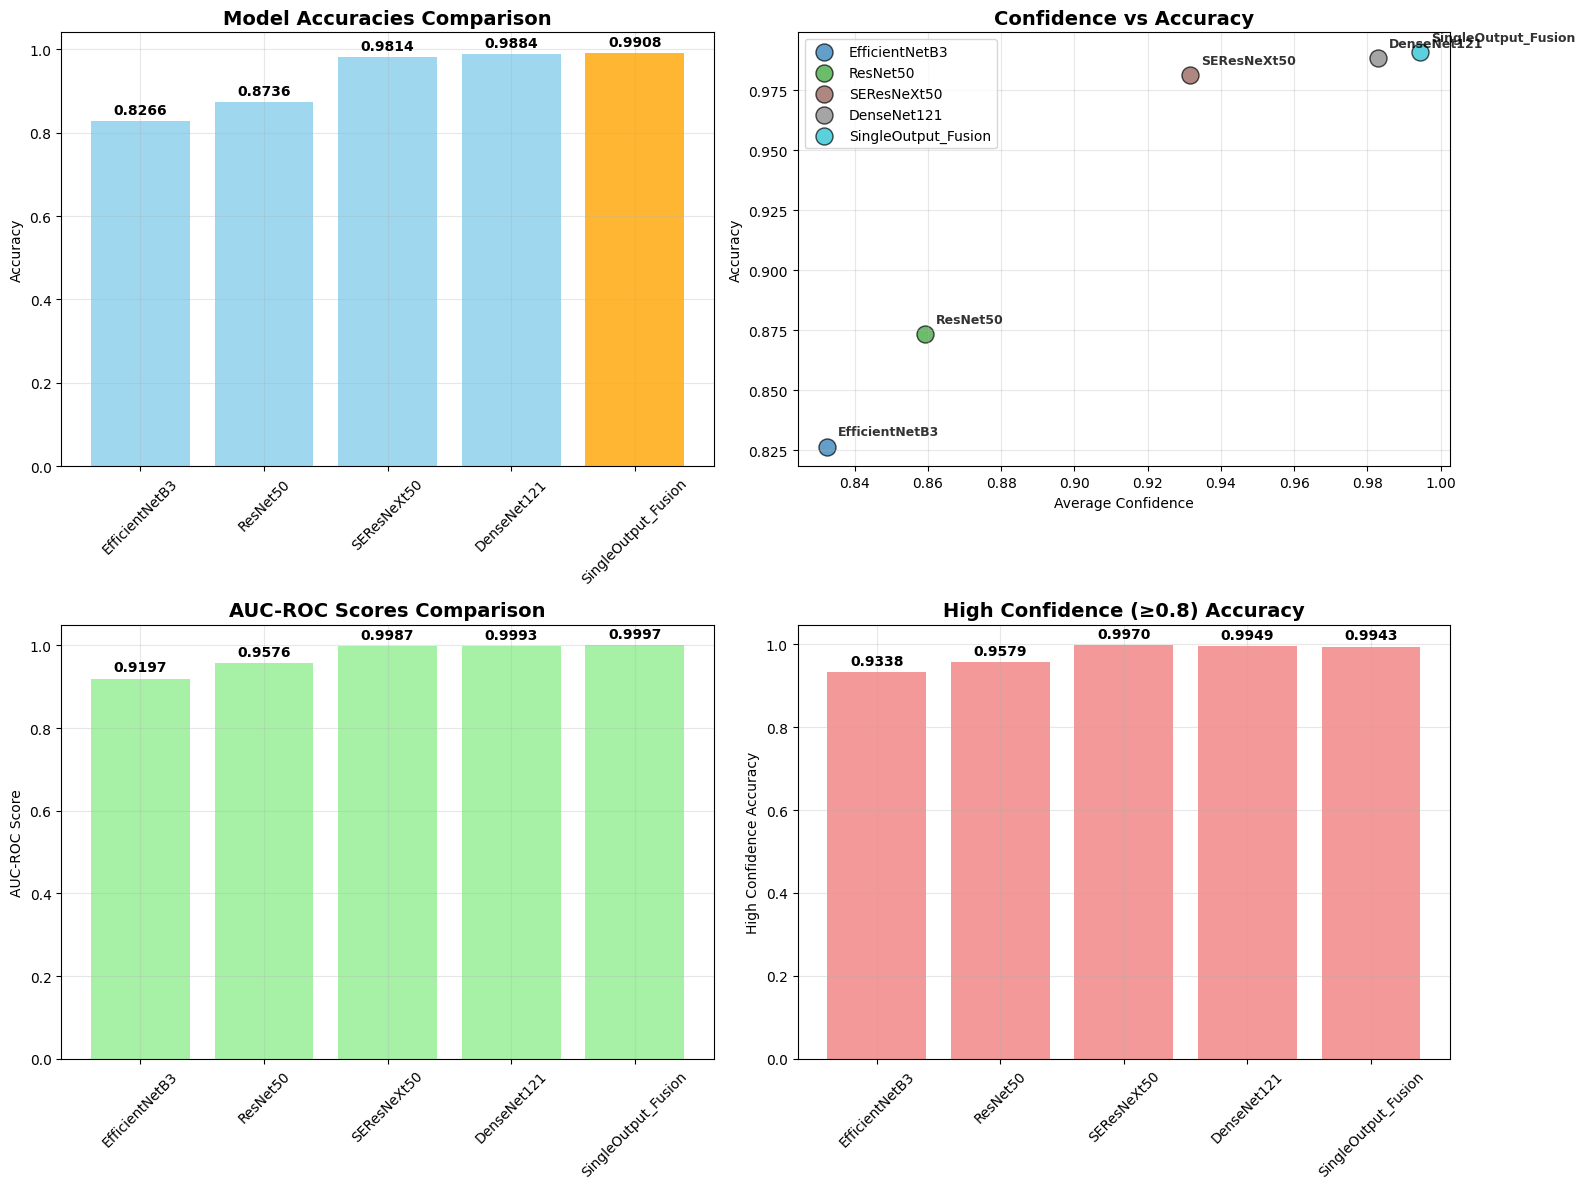


 KẾT QUẢ CUỐI CÙNG

BẢNG XẾP HẠNG MODEL:
 SingleOutput_Fusion  | Acc: 0.9908 | AUC: 0.9997 | Conf: 0.9945
 DenseNet121          | Acc: 0.9884 | AUC: 0.9993 | Conf: 0.9829
 SEResNeXt50          | Acc: 0.9814 | AUC: 0.9987 | Conf: 0.9317
4. ResNet50             | Acc: 0.8736 | AUC: 0.9576 | Conf: 0.8591
5. EfficientNetB3       | Acc: 0.8266 | AUC: 0.9197 | Conf: 0.8325

 TỔNG KẾT:
   • Model tốt nhất: SingleOutput_Fusion
   • Accuracy tốt nhất: 0.9908
   • Simple Ensemble: 0.9912
   • Single Output Fusion: 0.9908
   • Improvement:     -0.0004
   •  Simple Ensemble đủ tốt

📋 CONFUSION MATRIX CHO SingleOutput_Fusion:


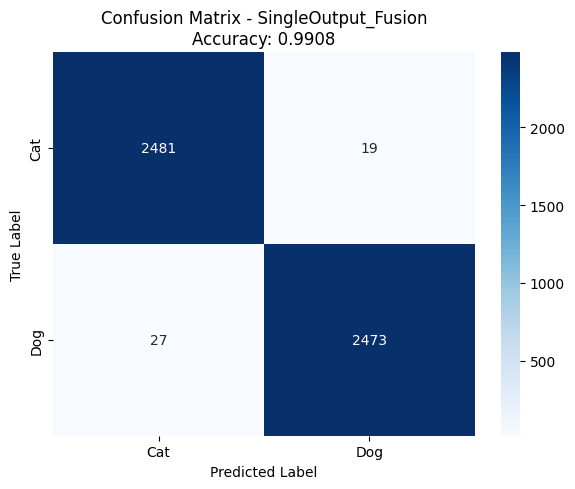

In [15]:
# Load model tốt nhất
fusion_model = keras.models.load_model("fusion_best_improved.keras")
fusion_model.save("single_output_fusion_final.keras")
print("\n Đã lưu model: single_output_fusion_final.keras")

# Đánh giá cuối cùng
print("\n" + "="*60)
print("ĐÁNH GIÁ CUỐI CÙNG")
print("="*60)

results = {}
for name, model in trained_models.items():
    results[name] = evaluate_model_probability(model, val_ds, np.array(val_labels), name)

results['SingleOutput_Fusion'] = evaluate_model_probability(
    fusion_model, val_ds, np.array(val_labels), 'SingleOutput_Fusion'
)

# So sánh với Simple Ensemble
def create_ensemble_from_best_models(best_models_dict, val_ds):
    """Tạo ensemble predictions từ các model tốt nhất"""
    ensemble_proba = []
    model_names = []
    
    for model_name, model_info in best_models_dict.items():
        pred_proba = get_pred_proba(model_info['model'], val_ds)
        ensemble_proba.append(pred_proba)
        model_names.append(model_name)
    
    ensemble_proba = np.array(ensemble_proba)
    avg_ensemble = np.mean(ensemble_proba, axis=0)
    
    return avg_ensemble, ensemble_proba, model_names

ensemble_proba, _, _ = create_ensemble_from_best_models(best_models, val_ds)
ensemble_pred = np.argmax(ensemble_proba, axis=1)
ensemble_acc = np.mean(ensemble_pred == np.array(val_labels))

fusion_acc = results['SingleOutput_Fusion']['accuracy']

print(f"\nSO SÁNH KẾT QUẢ:")
print(f"Simple Ensemble Accuracy: {ensemble_acc:.4f}")
print(f"Single Output Fusion Accuracy: {fusion_acc:.4f}")
print(f"Improvement: {fusion_acc - ensemble_acc:+.4f}")

# Visualization
def plot_final_comparison(results_dict, val_labels):
    """Vẽ biểu đồ so sánh các model"""
    models = list(results_dict.keys())
    accuracies = [results_dict[m]['accuracy'] for m in models]
    confidences = [results_dict[m]['avg_confidence'] for m in models]
    auc_scores = [results_dict[m]['auc_roc'] for m in models]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Bar chart accuracy
    colors = ['skyblue' if 'Fusion' not in m else 'orange' for m in models]
    bars = ax1.bar(models, accuracies, color=colors, alpha=0.8)
    ax1.set_title('Model Accuracies Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Confidence vs Accuracy scatter
    color_map = plt.cm.get_cmap('tab10', len(models))
    for i, (model, acc, conf) in enumerate(zip(models, accuracies, confidences)):
        ax2.scatter(conf, acc, color=color_map(i), s=150, label=model, alpha=0.7, edgecolors='black')
        ax2.annotate(model, (conf, acc), xytext=(8, 8), textcoords='offset points', 
                    fontsize=9, fontweight='bold', alpha=0.8)
    
    ax2.set_xlabel('Average Confidence')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Confidence vs Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # AUC-ROC comparison
    bars_auc = ax3.bar(models, auc_scores, color='lightgreen', alpha=0.8)
    ax3.set_title('AUC-ROC Scores Comparison', fontsize=14, fontweight='bold')
    ax3.set_ylabel('AUC-ROC Score')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    for bar, auc_val in zip(bars_auc, auc_scores):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{auc_val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # High confidence accuracy
    high_conf_accs = [results_dict[m]['high_conf_accuracy'] for m in models]
    bars_hc = ax4.bar(models, high_conf_accs, color='lightcoral', alpha=0.8)
    ax4.set_title('High Confidence (≥0.8) Accuracy', fontsize=14, fontweight='bold')
    ax4.set_ylabel('High Confidence Accuracy')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    
    for bar, hc_acc in zip(bars_hc, high_conf_accs):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{hc_acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n VẼ BIỂU ĐỒ SO SÁNH...")
plot_final_comparison(results, np.array(val_labels))

# In kết quả cuối cùng
print("\n KẾT QUẢ CUỐI CÙNG")
print("="*60)

sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
print("\nBẢNG XẾP HẠNG MODEL:")
for i, (name, metrics) in enumerate(sorted_results):
    rank = "" if i == 0 else "" if i == 1 else "" if i == 2 else f"{i+1}."
    print(f"{rank} {name:20} | Acc: {metrics['accuracy']:.4f} | AUC: {metrics['auc_roc']:.4f} | Conf: {metrics['avg_confidence']:.4f}")

best_model_name = sorted_results[0][0]
best_accuracy = sorted_results[0][1]['accuracy']

print(f"\n TỔNG KẾT:")
print(f"   • Model tốt nhất: {best_model_name}")
print(f"   • Accuracy tốt nhất: {best_accuracy:.4f}")
print(f"   • Simple Ensemble: {ensemble_acc:.4f}")
print(f"   • Single Output Fusion: {fusion_acc:.4f}")
print(f"   • Improvement:     {fusion_acc - ensemble_acc:+.4f}")

if fusion_acc > ensemble_acc:
    print(f"   •  Single Output Fusion hiệu quả hơn Simple Ensemble!")
else:
    print(f"   •  Simple Ensemble đủ tốt")

# Confusion matrix cho model tốt nhất
print(f"\n📋 CONFUSION MATRIX CHO {best_model_name}:")
best_pred_proba = results[best_model_name]['pred_proba']
best_pred_classes = np.argmax(best_pred_proba, axis=1)

cm = confusion_matrix(val_labels, best_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title(f'Confusion Matrix - {best_model_name}\nAccuracy: {results[best_model_name]["accuracy"]:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()